In [1]:
!pip install dython
import itertools
import pandas as pd
import pandas_profiling
import numpy as np
import scipy.stats
import re
import math
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.backends.backend_agg
import matplotlib.figure
import seaborn as sns
import datetime
import dython.nominal as dn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
vehicles_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/AlejandroPenaloza/cars-value-predictor/master/cars-features-dataset.csv')
vehicles_dataset.drop(columns='Unnamed: 0', inplace=True)
print(vehicles_dataset.shape)
vehicles_dataset.head()

(16920, 18)


,Make,Model,Year,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
0,Ford,Focus,2014.0,"35,795",Automatic,2.0L Inline-4 Gas,NaN,Charcoal Black,26 cty / 36 hwy,Gas,FWD,Tacoma,WA,SE Hatchback,2 reported accidents,Standard,NaN,"7,999"
1,Ford,F-150,2015.0,"128,146",Automatic,2.7L V-6 Gas Turbocharged,Unknown,Medium Earth Gray,19 cty / 26 hwy,Gas,RWD,Waxahachie,TX,XL SuperCrew 6.5\' Box RWD,0 reported accidents,NaN,Standard Bed,"15,991"
2,Mercedes-Benz,E-Class,2004.0,"135,000",Automatic,5.0L V-8 Gas,Black,Beige,16 cty / 22 hwy,Gas,AWD,Covina,CA,E 500 4MATIC Wagon,0 reported accidents,Standard,NaN,"5,950"
3,Hyundai,Elantra,2011.0,"135,670",Automatic,1.8L Inline-4 Gas,NaN,Gray,28 cty / 38 hwy,Gas,FWD,Miami,FL,NaN,0 reported accidents,Standard,NaN,"3,999"
4,Toyota,Prius,2012.0,"152,543",Automatic,1.8L Inline-4 Hybrid,White,Biege,51 cty / 48 hwy,Hybrid,FWD,Byhalia,MS,Five,1 reported accidents,Standard,NaN,"6,500"


## Exploratory Data Analysis

In [ ]:
pandas_profiling.ProfileReport(vehicles_dataset)

In [3]:
print(vehicles_dataset.info())
print(vehicles_dataset['Year'].describe())
vehicles_dataset.drop(columns='Year').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16920 entries, 0 to 16919
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Make                   16024 non-null  object 
 1   Model                  15997 non-null  object 
 2   Year                   16098 non-null  float64
 3   Mileage                16571 non-null  object 
 4   Transmission           16534 non-null  object 
 5   Engine                 13375 non-null  object 
 6   Exterior Color         11080 non-null  object 
 7   Interior Color         15635 non-null  object 
 8   MPG                    16553 non-null  object 
 9   Fuel Type              16584 non-null  object 
 10  Drive Type             16636 non-null  object 
 11  Location (City)        16207 non-null  object 
 12  Location (State)       16172 non-null  object 
 13  Style                  15173 non-null  object 
 14  Condition (Accidents)  16139 non-null  object 
 15  Op

,Make,Model,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
count,16024,15997,16571,16534,13375,11080,15635,16553,16584,16636,16207,16172,15173,16139,14679,1279,16004
unique,121,615,6442,2,122,577,325,274,7,5,1311,52,1327,5,4,3,3217
top,Ford,Sentra,"29,842",Automatic,2.5L Inline-4 Gas,Black,Black,29 cty / 37 hwy,Gas,FWD,Phoenix,TX,SE FWD,0 reported accidents,Standard,Short Bed,"9,995"
freq,2158,563,20,16036,2045,821,4577,638,15625,9719,235,1997,444,13441,9801,603,119


Or...

In [4]:
vehicles_dataset.dtypes

Make                      object
Model                     object
Year                     float64
Mileage                   object
Transmission              object
Engine                    object
Exterior Color            object
Interior Color            object
MPG                       object
Fuel Type                 object
Drive Type                object
Location (City)           object
Location (State)          object
Style                     object
Condition (Accidents)     object
Options Level             object
Bed Length                object
Price                     object
dtype: object

In [5]:
vehicles_dataset.isnull().sum(axis=0)

Make                       896
Model                      923
Year                       822
Mileage                    349
Transmission               386
Engine                    3545
Exterior Color            5840
Interior Color            1285
MPG                        367
Fuel Type                  336
Drive Type                 284
Location (City)            713
Location (State)           748
Style                     1747
Condition (Accidents)      781
Options Level             2241
Bed Length               15641
Price                      916
dtype: int64

In [6]:
# the following is an array with columns sorted by nulls count within them.
columns_by_nulls = vehicles_dataset.isnull().sum().sort_values(ascending=True)
print(columns_by_nulls)
sorted_columns = columns_by_nulls.index.to_numpy()
sorted_columns

Drive Type                 284
Fuel Type                  336
Mileage                    349
MPG                        367
Transmission               386
Location (City)            713
Location (State)           748
Condition (Accidents)      781
Year                       822
Make                       896
Price                      916
Model                      923
Interior Color            1285
Style                     1747
Options Level             2241
Engine                    3545
Exterior Color            5840
Bed Length               15641
dtype: int64


array(['Drive Type', 'Fuel Type', 'Mileage', 'MPG', 'Transmission',
       'Location (City)', 'Location (State)', 'Condition (Accidents)',
       'Year', 'Make', 'Price', 'Model', 'Interior Color', 'Style',
       'Options Level', 'Engine', 'Exterior Color', 'Bed Length'],
      dtype=object)

This high quantity of allegedly null values is due to lack of information when inputting specifications in each car listing from its owner or merchant.
Some of them will be dropped but most of them will be labeled as another data category.

In [7]:
vehicles_dataset.dropna(subset=['Make', 'Model'], inplace=True)
sorted_columns = np.setdiff1d(sorted_columns, np.array(['Make', 'Model']), assume_unique=True)
vehicles_dataset.shape

(15983, 18)

Make and model are too important to have as an specific information for each row, so the ones were Make and Model are missing were dropped.

In [8]:
sorted_columns[0]

'Drive Type'

Now, 'Drive Type' will be analyzed.

In [9]:
vehicles_dataset['Drive Type'].value_counts()

FWD        9347
AWD        2648
4WD        2144
RWD        1813
Unknown       8
Name: Drive Type, dtype: int64

In [10]:
vehicles_dataset['Drive Type'].isnull().sum()

23

This variable has just 23 null values. In addition to that there is one category called 'Unknown', which has only 8 occurrences.
The rows presenting these values are going to be eliminated.

In [11]:
vehicles_dataset["Drive Type"] = vehicles_dataset["Drive Type"].apply(
    lambda dt: (dt, np.NaN)[dt == 'Unknown'])
vehicles_dataset.dropna(subset=["Drive Type"], inplace=True)

In [12]:
# Function to display next feature to analyze and edited
# dataframe shape, after being done with previous one
def display_next_feature(n=1):
  global sorted_columns
  sorted_columns = sorted_columns[n:]
  return print(sorted_columns[0], "\n", vehicles_dataset.shape)
               
  
display_next_feature()

Fuel Type 
 (15952, 18)


The next variable with the least amount of null values is 'Fuel Type'.

In [13]:
print(vehicles_dataset['Fuel Type'].value_counts())
vehicles_dataset['Fuel Type'].isnull().sum()

Gas         14999
Hybrid        482
Diesel        266
Plug-In        99
Electric       64
Hydrogen        3
CNG             2
Name: Fuel Type, dtype: int64


37

'CNG' and 'Hydrogen will be dismissed, they have but 5 presences. 

In [14]:
vehicles_dataset['Fuel Type'] = vehicles_dataset['Fuel Type'].apply(
    lambda ft: (ft, np.NaN)[ft in ['Hydrogen', 'CNG']])
vehicles_dataset.dropna(subset=['Fuel Type'], inplace=True)

In [15]:
display_next_feature()

Mileage 
 (15910, 18)


'Mileage' column comes on.

In [16]:
print(vehicles_dataset['Mileage'].value_counts())
vehicles_dataset['Mileage'].isnull().sum()

29,842     20
148,040    19
152,997    18
51,821     16
92,897     15
           ..
26,476      1
168,586     1
10,406      1
10,482      1
115,211     1
Name: Mileage, Length: 6271, dtype: int64


12

In [17]:
vehicles_dataset.dropna(subset=['Mileage'], inplace=True)

In [18]:
vehicles_dataset['Mileage'] = vehicles_dataset['Mileage'].apply(
    lambda m: m.replace(',', ''))
vehicles_dataset['Mileage'] = vehicles_dataset['Mileage'].astype('int64')

In [19]:
mileage_median = np.median(vehicles_dataset['Mileage'])
print("Median of 'Mileage' data is", mileage_median)
scipy.stats.describe(vehicles_dataset['Mileage'])

Median of 'Mileage' data is 40044.0


DescribeResult(nobs=15898, minmax=(5, 428197), mean=58815.70228959618, variance=2178329907.811407, skewness=1.375201333977781, kurtosis=1.9200097611263107)

Text(0.5, 0, 'Occurrences')

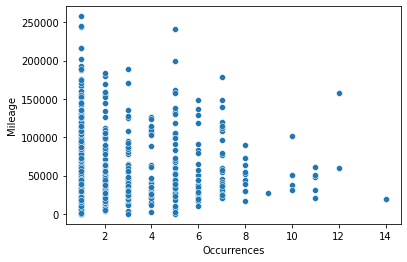

In [20]:
ax = sns.scatterplot(x=vehicles_dataset['Mileage'].value_counts(), 
                     y=vehicles_dataset['Mileage'], data=vehicles_dataset)
ax.set_xlabel('Occurrences')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


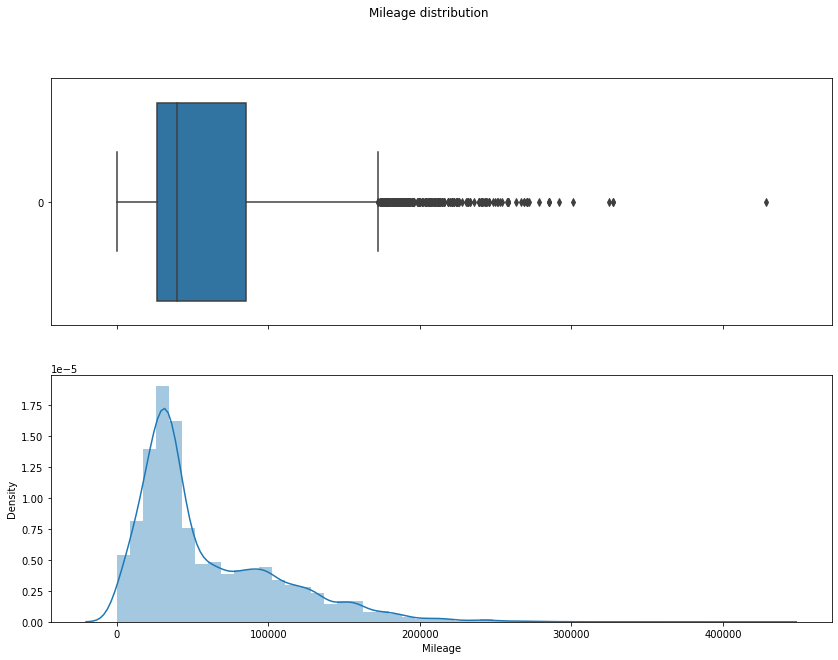

In [21]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(14, 10))
fig.suptitle('Mileage distribution')
sns.boxplot(orient='h', data=vehicles_dataset['Mileage'], ax=ax_box)
sns.distplot(vehicles_dataset['Mileage'], ax=ax_hist)

It ts clear that many outliers are present here. They are to be dealt with by using 1.5 x Interquartile Range Rule and Z Score measurements.

In [22]:
# absolute value of z-score for every mileage
mileage_std = np.std(vehicles_dataset['Mileage'])
print("Threshold is to be", 3*mileage_std)
z_score = np.abs(scipy.stats.zscore(vehicles_dataset['Mileage']))
z_score

Threshold is to be 140013.34221515374


array([0.49325376, 1.48550767, 1.6323651 , ..., 0.6199274 , 0.25316949,
       1.08355464])

In [23]:
# Quartiles and IQR definition
mileage_iqr = scipy.stats.iqr(vehicles_dataset['Mileage'])

# mileage_iqr = vehicles_dataset['Mileage'].apply(scipy.stats.iqr)
mileage_quartile1 = np.percentile(vehicles_dataset['Mileage'], 25)
mileage_quartile3 = np.percentile(vehicles_dataset['Mileage'], 75)

Z-Score filtering applied by comparing their value with each mileage score, keeping the rows within the +-3 standard deviation range.

In [24]:
# z-score filtered dataframe
z_score_outliers_n = vehicles_dataset.shape[0] - len(vehicles_dataset[z_score <= 3]['Mileage'])
vehicles_dataset = vehicles_dataset[z_score <= 3]
print("New number of rows:", vehicles_dataset.shape[0])
vehicles_dataset['Mileage'].value_counts()

New number of rows: 15705


29842     20
148040    19
152997    18
51821     16
94500     15
          ..
32444      1
120497     1
114348     1
51822      1
38909      1
Name: Mileage, Length: 6173, dtype: int64

In [25]:
print("So,", z_score_outliers_n, 
      "fields have been declared as outliers, thereby left away.")
max_mileage = vehicles_dataset['Mileage'].max()

So, 193 fields have been declared as outliers, thereby left away.


Interquartile Range usage for restricting the array values spread.

In [26]:
# Dataset taking away outliers according to 1.5 times the interquartile range.
IQRx1p5_df = vehicles_dataset[(vehicles_dataset['Mileage'] > mileage_quartile1 - 1.5 * mileage_iqr) & (
      vehicles_dataset['Mileage'] < mileage_quartile3 + 1.5 * mileage_iqr)]
IQRx1p5_rows_n = len(vehicles_dataset['Mileage']) - len(IQRx1p5_df['Mileage'])
print('Current number of rows', len(vehicles_dataset['Mileage']), 
      "- number if all rows eliminated for 1.5x IQR", len(IQRx1p5_df['Mileage']),
      "=", IQRx1p5_rows_n)

Current number of rows 15705 - number if all rows eliminated for 1.5x IQR 15454 = 251


Due to limiting the values range whisker to 1.5 IQR takes away over 200 more rows (nearly 500 from original dataset, which is a lot to this standard), some of those values will be kept, by representing the median value. 

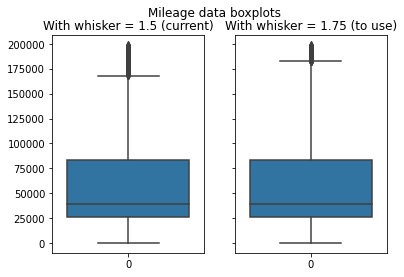

In [27]:
fig, (box1, box2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Mileage data boxplots')
sns.boxplot(orient='v', data=vehicles_dataset['Mileage'], ax=box1, whis=1.5)
box1.set_title('With whisker = 1.5 (current)')
sns.boxplot(orient='v', data=vehicles_dataset['Mileage'], ax=box2, whis=1.75)
box2.set_title('With whisker = 1.75 (to use)')
plt.show()

In [28]:
# Dataset taking away outliers according to 1.75 times the interquartile range
IQRx1p75_df = vehicles_dataset[(vehicles_dataset['Mileage'] > mileage_quartile1 - 1.75 * mileage_iqr) & (
      vehicles_dataset['Mileage'] < mileage_quartile3 + 1.75 * mileage_iqr)]
IQRx1p75_rows_n = len(vehicles_dataset['Mileage']) - len(IQRx1p75_df['Mileage'])
print("Current number of rows ", len(vehicles_dataset['Mileage']), 
      " - number if all rows eliminated for 1.75x IQR ", len(IQRx1p75_df['Mileage']),
      " = ", IQRx1p75_rows_n, ".", sep="")
print("And the rest (will be changed instead of eliminated): ", IQRx1p5_rows_n - IQRx1p75_rows_n, ".", sep="")

Current number of rows 15705 - number if all rows eliminated for 1.75x IQR 15635 = 70.
And the rest (will be changed instead of eliminated): 181.


Now, these 70 rows will be dropped and the rest of outliers (181) are to storage the mileage median value.

In [29]:
vehicles_dataset = IQRx1p75_df

# Given that there are no low outliers, we can determine what outliers value to replace by comparing with the new max mileage value
vehicles_dataset['Mileage'].where(vehicles_dataset['Mileage'] <= IQRx1p5_df['Mileage'].max(), other=mileage_median, inplace=True)

In [30]:
display_next_feature()

MPG 
 (15635, 18)


Following into the variables list with the least null values, 'MPG' comes up.

In [31]:
print(vehicles_dataset['MPG'].value_counts())
vehicles_dataset['MPG'].isnull().sum()

17 cty / 25 hwy      597
29 cty / 37 hwy      590
N/A cty / N/A hwy    508
28 cty / 39 hwy      381
26 cty / 33 hwy      364
                    ... 
150 cty / 122 hwy      1
49 cty / 43 hwy        1
15 cty / 17 hwy        1
24 cty / 25 hwy        1
126 cty / 105 hwy      1
Name: MPG, Length: 269, dtype: int64


18

This column has only 18 null values, however, they are also represented as True in 'N/A cty / N/A hwy', as seen down below.
Since there are around 500 of these values, they will be categorized as well.

In [32]:
sorted(list(vehicles_dataset.dropna(subset=['MPG'])['MPG'].unique()))

['10 cty / 16 hwy',
 '10 cty / 17 hwy',
 '101 cty / 93 hwy',
 '102 cty / 105 hwy',
 '104 cty / 91 hwy',
 '106 cty / 92 hwy',
 '11 cty / 15 hwy',
 '11 cty / 16 hwy',
 '11 cty / 17 hwy',
 '11 cty / 18 hwy',
 '11 cty / N/A hwy',
 '12 cty / 14 hwy',
 '12 cty / 16 hwy',
 '12 cty / 17 hwy',
 '12 cty / 18 hwy',
 '12 cty / 19 hwy',
 '120 cty / 112 hwy',
 '121 cty / 103 hwy',
 '122 cty / 108 hwy',
 '122 cty / 93 hwy',
 '124 cty / 94 hwy',
 '126 cty / 101 hwy',
 '126 cty / 105 hwy',
 '126 cty / 99 hwy',
 '129 cty / 102 hwy',
 '13 cty / 16 hwy',
 '13 cty / 17 hwy',
 '13 cty / 18 hwy',
 '13 cty / 19 hwy',
 '13 cty / 20 hwy',
 '13 cty / 21 hwy',
 '13 cty / 22 hwy',
 '137 cty / 111 hwy',
 '14 cty / 17 hwy',
 '14 cty / 18 hwy',
 '14 cty / 19 hwy',
 '14 cty / 20 hwy',
 '14 cty / 21 hwy',
 '14 cty / 22 hwy',
 '14 cty / 23 hwy',
 '14 cty / 24 hwy',
 '15 cty / 17 hwy',
 '15 cty / 18 hwy',
 '15 cty / 19 hwy',
 '15 cty / 20 hwy',
 '15 cty / 21 hwy',
 '15 cty / 22 hwy',
 '15 cty / 23 hwy',
 '15 cty / 24 hwy

In [33]:
def MPG_categorize(MPG):
    if MPG in ['N/A cty / N/A hwy', np.NaN]:
        return 'Another'
    else:
        cty = int(re.findall('[0-9]+ c', str(MPG))[0][:-2])
        hwy = re.findall('/ [0-9]+', str(MPG))
        if hwy == []:
            return 'Another'
        elif cty >= 60:
            return 'up from 60 cty / up from 50 hwy'
        else:
            hwy = int(hwy[0][2:])
            return str(cty)[0] + "0-" + str(cty)[0] + "9 cty / " + str(hwy)[0] + "0-" + str(hwy)[0] + "9 hwy"

vehicles_dataset['MPG'] = vehicles_dataset['MPG'].apply(MPG_categorize)
vehicles_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              6961
10-19 cty / 20-29 hwy              4112
20-29 cty / 20-29 hwy              1861
30-39 cty / 40-49 hwy               635
Another                             527
30-39 cty / 30-39 hwy               476
10-19 cty / 10-19 hwy               383
40-49 cty / 40-49 hwy               301
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
40-49 cty / 30-39 hwy                45
50-59 cty / 40-49 hwy                40
50-59 cty / 50-59 hwy                 9
30-39 cty / 20-29 hwy                 6
Name: MPG, dtype: int64

30, 40 and 50 cty categories are being gathered so outliers disappear.

In [34]:
def MPG_categorize2(MPG):
    if MPG in ['30-39 cty / 20-29 hwy', '30-39 cty / 30-39 hwy']:
        return '30-39 cty / 20-39 hwy'
    elif MPG in ['50-59 cty / 40-49 hwy', '50-59 cty / 50-59 hwy']:
        return '50-59 cty / 40-59 hwy'
    elif MPG in ['40-49 cty / 30-39 hwy', '40-49 cty / 40-49 hwy']:
        return '40-49 cty / 30-49 hwy'
    else:
        return MPG
    

vehicles_dataset['MPG'] = vehicles_dataset['MPG'].apply(MPG_categorize2)
vehicles_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              6961
10-19 cty / 20-29 hwy              4112
20-29 cty / 20-29 hwy              1861
30-39 cty / 40-49 hwy               635
Another                             527
30-39 cty / 20-39 hwy               482
10-19 cty / 10-19 hwy               383
40-49 cty / 30-49 hwy               346
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
50-59 cty / 40-59 hwy                49
Name: MPG, dtype: int64

In [35]:
display_next_feature()

Transmission 
 (15635, 18)


'Transmission' feature presents only two true values, as logically thought. We will just get rid of null values then.

In [36]:
print(vehicles_dataset['Transmission'].isnull().sum())
vehicles_dataset['Transmission'].value_counts()

13


Automatic    15153
Manual         469
Name: Transmission, dtype: int64

In [37]:
vehicles_dataset.dropna(subset=['Transmission'], inplace=True)

In [38]:
display_next_feature()

Location (City) 
 (15622, 18)


The places where the vehicles are located are defined by city and state as two variables -'Location (City)' and Location (State)'-.

These variables describing vehicle location will be analyzed later on.

In [39]:
display_next_feature(2)

Condition (Accidents) 
 (15622, 18)


'Condition (Accidents)' is the next characteristic to check out.

In [40]:
print(vehicles_dataset['Condition (Accidents)'].value_counts())
vehicles_dataset['Condition (Accidents)'].isnull().sum()

0 reported accidents    12916
1 reported accidents     2186
2 reported accidents      324
3 reported accidents       37
4 reported accidents       11
Name: Condition (Accidents), dtype: int64


148

There are 148 null values, and they will be replaced by another category ('Unknown), along the value '4 reported accidents', as it has very few instances.

In [41]:
vehicles_dataset['Condition (Accidents)'] = vehicles_dataset['Condition (Accidents)'].apply(
    lambda cond: (cond, 'Unknown')[cond in ['4 reported accidents', np.NaN]])
vehicles_dataset['Condition (Accidents)'].value_counts()

0 reported accidents    12916
1 reported accidents     2186
2 reported accidents      324
Unknown                   159
3 reported accidents       37
Name: Condition (Accidents), dtype: int64

In [42]:
display_next_feature()

Year 
 (15622, 18)


Intuitively, vehicles model years is represented in 'Year' column.

In [43]:
print(vehicles_dataset['Year'].isnull().sum())
vehicles_dataset['Year'].value_counts()

6


2019.0    4211
2017.0    3918
2018.0    1116
2016.0     922
2015.0     802
2014.0     720
2020.0     662
2013.0     657
2012.0     488
2010.0     377
2011.0     373
2007.0     275
2009.0     253
2008.0     234
2006.0     167
2005.0     127
2004.0      92
2003.0      83
2002.0      57
2001.0      38
1999.0      16
2000.0      14
1998.0       9
1997.0       5
Name: Year, dtype: int64

In [44]:
vehicles_dataset['Year'] = vehicles_dataset['Year'].where(
    vehicles_dataset['Year'] > 2000, other='Other')
vehicles_dataset['Year'].fillna('Other', inplace=True)
vehicles_dataset['Year'] = vehicles_dataset['Year'].astype('object')
vehicles_dataset['Year'].value_counts()

2019.0    4211
2017.0    3918
2018.0    1116
2016.0     922
2015.0     802
2014.0     720
2020.0     662
2013.0     657
2012.0     488
2010.0     377
2011.0     373
2007.0     275
2009.0     253
2008.0     234
2006.0     167
2005.0     127
2004.0      92
2003.0      83
2002.0      57
Other       50
2001.0      38
Name: Year, dtype: int64

In [46]:
display_next_feature()

Interior Color 
 (15622, 18)


'Interior Color' variable is next to evaluate.

In [47]:
vehicles_dataset['Interior Color'].value_counts()

Black                4330
Charcoal             1700
Unknown              1392
Gray                 1234
Jet Black             860
                     ... 
Dark Brown/Ivory        1
Inferno Orange          1
Medium Dk Flint         1
Medium Flint Grey       1
Tan Leather             1
Name: Interior Color, Length: 318, dtype: int64

In [48]:
print("'Interior Color' has", vehicles_dataset['Interior Color'].nunique(), "unique values")
print("and 'Exterior Color' has ", vehicles_dataset['Exterior Color'].nunique(), ".", sep="")

'Interior Color' has 318 unique values
and 'Exterior Color' has 555.


Both 'Interior Color' and 'Exterior Color' has a lot of unique values, but they can be regrouped given that these values represent almost the same color for each case, by category.

In [49]:
print("'Interior Color' has", vehicles_dataset['Interior Color'].isnull().sum(), "null values")
print("and 'Exterior Color' has ", vehicles_dataset['Exterior Color'].isnull().sum(), "!", sep="")

'Interior Color' has 763 null values
and 'Exterior Color' has 5126!


We will create a function which re-categorizes color values (including null values, given that there are a lot of them, 763 and 5126 respectively).

In [50]:
sorted_columns = np.setdiff1d(sorted_columns, np.array(['Exterior Color']), assume_unique=True)

The following function will check whether the passed color names belong to the same category.

In [51]:
def color_in(color, *argc):
    checks = []
    for arg in argc:
        if arg in str(color).lower():
            checks.append(True)
        else:
            checks.append(False)
    if any(checks):
        return True
    else:
        return False

Now, this function will tell if the conditions are met so that it categorizes the original values to this set-up. 

In [52]:
def colors_categorize(ext_color):
    if color_in(ext_color, "black") or "Obsidian" == ext_color:
        return "Black"
    elif color_in(
        ext_color, "white", "glacier") or ext_color in ["Fresh Powder", "Blizzard Pearl", "Starfire Pearl"]:
        return "White"
    elif color_in(ext_color, "green"):
        return "Green"
    elif color_in(ext_color, "blue", "aqua"):
        return "Blue"
    elif color_in(
        ext_color, "silver", "gray", "magnetic", "pearlcoat", "tungsten", 
        "graphite", "gun", "platinum", "titanium", "billet"):
        return "Silver or Grey"
    elif color_in(ext_color, "red", "cherry", "ruby", "sun", "rosso", "scarlet"):
        return "Red"
    elif color_in(ext_color, "gold"):
        return "Gold"
    elif color_in(ext_color, "brown", "beige"):
        return "Beige or Brown"
    elif color_in(ext_color, "yellow"):
        return "Yellow"
    else:
        return "Other"

In [53]:
vehicles_dataset['Interior Color'] = vehicles_dataset['Interior Color'].apply(colors_categorize)
vehicles_dataset['Interior Color'].value_counts()

Black             6565
Other             6494
Silver or Grey    1926
Beige or Brown     590
Red                 21
White               13
Blue                 7
Green                5
Gold                 1
Name: Interior Color, dtype: int64

In [54]:
# keeping on filtering the values
vehicles_dataset['Interior Color'] = vehicles_dataset['Interior Color'].apply(
    lambda i_color: (i_color, 'Other')[i_color in ['Gold', 'Green', 'Blue']])
vehicles_dataset['Interior Color'].value_counts()

Black             6565
Other             6507
Silver or Grey    1926
Beige or Brown     590
Red                 21
White               13
Name: Interior Color, dtype: int64

In [55]:
vehicles_dataset['Exterior Color'].value_counts()

Black             757
Oxford White      423
Summit White      392
Gray              376
White             340
                 ... 
Sunset Orange       1
Denim               1
Sky Blue Pearl      1
Hyper Blue          1
Designo Silver      1
Name: Exterior Color, Length: 555, dtype: int64

In [56]:
vehicles_dataset['Exterior Color'] = vehicles_dataset['Exterior Color'].apply(colors_categorize)
vehicles_dataset['Exterior Color'].value_counts()

Other             5682
White             3232
Black             2613
Silver or Grey    2527
Blue               809
Red                631
Beige or Brown      55
Gold                46
Green               22
Yellow               5
Name: Exterior Color, dtype: int64

In [57]:
vehicles_dataset['Exterior Color'].where(
    vehicles_dataset['Exterior Color'] != 'Yellow', other='Other', inplace=True)
vehicles_dataset['Exterior Color'].value_counts()

Other             5687
White             3232
Black             2613
Silver or Grey    2527
Blue               809
Red                631
Beige or Brown      55
Gold                46
Green               22
Name: Exterior Color, dtype: int64

In [58]:
display_next_feature()

Style 
 (15622, 18)


'Style' feature is up.

In [59]:
print(vehicles_dataset['Style'].isnull().sum())
vehicles_dataset['Style'].value_counts()

1128


SE FWD                       425
SXT                          382
LE CVT                       369
SV CVT                       351
LX Sedan CVT                 328
                            ... 
SLT Quad Cab Long Bed 2WD      1
XL Crew Cab 8\' Bed 4WD        1
C 63 AMG Sedan RWD             1
SX Koup Manual                 1
2.5i Manual (PZEV)             1
Name: Style, Length: 1285, dtype: int64

In [60]:
list(vehicles_dataset['Style'].unique())

['SE Hatchback',
 "XL SuperCrew 6.5\\' Box RWD",
 'E 500 4MATIC Wagon',
 nan,
 'Five',
 'E 350 4MATIC Luxury Sedan',
 'EX-L 4WD',
 'S CVT',
 'Hybrid Limited AWD',
 'LE I4 Automatic',
 'SE AWD',
 '3500 LT LWB',
 'Hybrid Titanium FWD',
 'LT with 1LT',
 'Laredo 4WD',
 'SXT',
 'S 4WD',
 'SL AWD CVT',
 'SE FWD',
 'LX Sedan Automatic',
 'LS 460 RWD',
 'SportWagen TDI DSG',
 'SV CVT',
 'Turbo Manual',
 'Carrera S',
 'Carrera GTS',
 'E 300 Sedan RWD',
 'Carrera 4S Cabriolet',
 '2.5i Premium CVT (PZEV)',
 'EX-L AWD',
 'C 300 Sedan 4MATIC',
 'LTZ 4WD',
 'Hatchback',
 '328i Sedan',
 'XLT FWD',
 'SEL FWD',
 'SRT8',
 'M40i',
 'LX FWD',
 'Sport Sedan CVT',
 'SEL 2.4L',
 'Denali FWD',
 'LT 4WD',
 'S Hardtop 2-Door',
 'RX 350 FWD',
 '2.5 SR',
 'SE',
 '+ Automatic',
 'Z71 4WD',
 'SR FWD',
 'GLS 450 4MATIC',
 'SV FWD',
 '3.0si AWD',
 'SE 2.4L AWD',
 'LX',
 'SE Automatic',
 'NX Turbo FWD',
 'GT FWD',
 'SE Plus AWD',
 'SXT RWD',
 'EcoBoost Fastback',
 'Hybrid SE FWD',
 'S\\xa0Automatic',
 'ES 350',
 'SE S

'Bed Length' is next to go through.

In [61]:
print("'Bed Length' column has", vehicles_dataset["Bed Length"].isnull().sum(), "null values.")
print("The other ones (", vehicles_dataset["Bed Length"].notnull().sum(), ") are:", sep="")
vehicles_dataset['Bed Length'].value_counts()

'Bed Length' column has 14460 null values.
The other ones (1162) are:


Short Bed       544
Standard Bed    501
Long Bed        117
Name: Bed Length, dtype: int64

As seen above the bed length is null for almost all cases, so it will be discarded.

In [62]:
vehicles_dataset.drop(columns='Bed Length', inplace=True)
vehicles_dataset.columns

Index(['Make', 'Model', 'Year', 'Mileage', 'Transmission', 'Engine',
       'Exterior Color', 'Interior Color', 'MPG', 'Fuel Type', 'Drive Type',
       'Location (City)', 'Location (State)', 'Style', 'Condition (Accidents)',
       'Options Level', 'Price'],
      dtype='object')

In [ ]:
cols_by_nulls.pop("Bed Length")

Now, 

Like there are just a few cases where the vehicles are yellow or green, we will get rid of these values.

In [ ]:
colors_to_drop = list(vehicles_dataset['Exterior Color'].value_counts().index[-4:])
colors_to_drop

['Beige or Brown', 'Gold', 'Green', 'Yellow']

In [ ]:
indexes = []


for color in colors_to_drop:
    indexes += list(cars_dataset[cars_dataset["Exterior Color"] == color].index)
    
    
vehicles_dataset.drop(indexes, inplace=True)
vehicles_dataset.shape

(15622, 17)

Text(0.5, 1.0, 'Exterior colors by occurrences')

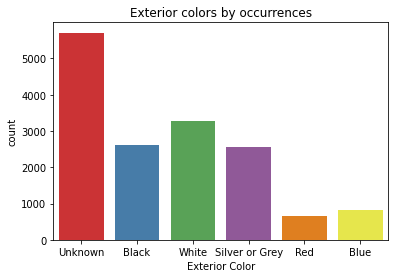

In [ ]:
ax = sns.countplot(x="Exterior Color", data=vehicles_dataset, palette="Set1")
ax.set_title("Exterior colors by occurrences")

Now, 'Engine' will be analyzed.

In [ ]:
vehicles_dataset['Engine'].isnull().sum()

2976

In [ ]:
vehicles_dataset['Engine'].value_counts()

2.5L Inline-4 Gas             1972
2.4L Inline-4 Gas             1354
1.8L Inline-4 Gas             1345
3.6L V-6 Gas                  1319
2.0L Inline-4 Gas             1274
                              ... 
6.6L V-12 Gas Turbocharged       1
3.0L V-6 Hybrid                  1
5.0L V-10 Gas                    1
3.2L Flat-6 Gas                  1
2.9L V-6 Gas Turbocharged        1
Name: Engine, Length: 119, dtype: int64

We are going to check on all the variants for each 'Inline', 'Flat' and 'Vs' engines, so we can filter them into more crowded categories

In [ ]:
sorted(vehicles_dataset['Engine'].value_counts().index.to_list())

['0.6L Inline-2 Plug-In',
 '1.0L Inline-3 Gas',
 '1.2L Inline-3 Gas',
 '1.3L Inline-4 Hybrid',
 '1.4L Inline-4 Gas',
 '1.4L Inline-4 Plug-In',
 '1.5L Inline-4 Gas',
 '1.5L Inline-4 Hybrid',
 '1.5L Inline-4 Plug-In',
 '1.6L Inline-4 Gas',
 '1.6L Inline-4 Hybrid',
 '1.7L Inline-4 Gas',
 '1.8L Inline-4 Gas',
 '1.8L Inline-4 Hybrid',
 '1.8L Inline-4 Plug-In',
 '2.0L Flat-4 Gas',
 '2.0L Inline-4 Gas',
 '2.0L Inline-4 Hybrid',
 '2.0L Inline-4 Plug-In',
 '2.0L V-4 Gas Turbocharged',
 '2.2L Inline-4 Gas',
 '2.3L Inline-4 Gas',
 '2.3L V-4 Gas Turbocharged',
 '2.4L Inline-4 Gas',
 '2.4L Inline-4 Hybrid',
 '2.4L Inline-5 Gas',
 '2.5L Flat-4 Gas',
 '2.5L Flat-6 Gas',
 '2.5L Inline-4 Gas',
 '2.5L Inline-4 Hybrid',
 '2.5L Inline-5 Gas',
 '2.5L Inline-6 Gas',
 '2.5L V-6 Gas',
 '2.7L Flat-6 Gas',
 '2.7L Inline-4 Gas',
 '2.7L V-6 Gas',
 '2.7L V-6 Gas Turbocharged',
 '2.8L V-6 Gas',
 '2.9L Inline-4 Gas',
 '2.9L V-6 Gas Turbocharged',
 '3.0L Flat-6 Gas',
 '3.0L Inline-6 Gas',
 '3.0L V-6 Gas',
 '3.0L V-6 

In [ ]:
for j in ["Inline", "Flat", "V"]:

    for i in vehicles_dataset['Engine'].value_counts().index.to_list():
        if j in i:
            print(i)

2.5L Inline-4 Gas
2.4L Inline-4 Gas
1.8L Inline-4 Gas
2.0L Inline-4 Gas
1.6L Inline-4 Gas
2.0L Inline-4 Hybrid
1.8L Inline-4 Hybrid
3.0L Inline-6 Gas
2.5L Inline-4 Hybrid
1.5L Inline-4 Gas
2.4L Inline-4 Hybrid
0.6L Inline-2 Plug-In
1.5L Inline-4 Hybrid
1.4L Inline-4 Plug-In
2.5L Inline-5 Gas
2.0L Inline-4 Plug-In
3.2L Inline-6 Gas
2.2L Inline-4 Gas
2.7L Inline-4 Gas
1.2L Inline-3 Gas
2.3L Inline-4 Gas
4.2L Inline-6 Gas
1.8L Inline-4 Plug-In
2.5L Inline-6 Gas
4.7L Inline-8 Gas
3.7L Inline-5 Gas
1.3L Inline-4 Hybrid
2.4L Inline-5 Gas
1.5L Inline-4 Plug-In
4.0L Inline-6 Gas
2.9L Inline-4 Gas
1.6L Inline-4 Hybrid
1.4L Inline-4 Gas
1.7L Inline-4 Gas
1.0L Inline-3 Gas
3.5L Inline-5 Gas
2.5L Flat-4 Gas
2.0L Flat-4 Gas
3.8L Flat-6 Gas
3.6L Flat-6 Gas
3.0L Flat-6 Gas
2.5L Flat-6 Gas
2.7L Flat-6 Gas
3.4L Flat-6 Gas
3.2L Flat-6 Gas
3.6L V-6 Gas
3.5L V-6 Gas
5.3L V-8 Gas
5.7L V-8 Gas
4.0L V-6 Gas
3.5L V-6 Gas Turbocharged
5.0L V-8 Gas
6.0L V-8 Gas
3.7L V-6 Gas
6.2L V-8 Gas
3.8L V-6 Gas
3.0L V-6 Ga

In [ ]:
def engine_categorize(engine_type):
    if "V-" in engine_type:
        return re.findall("V.+", engine_type)[0]
    elif "Inline" in engine_type:
        return re.findall("I.+", engine_type)[0]
    elif "Flat" in engine_type:
        return re.findall("F.+", engine_type)[0]
    else:
        return "Another"

In [ ]:
re.findall("V-[1-8][0-2]?", "5.4L V-10 Gas Supercharged")

['V-10']

In [ ]:
vehicles_dataset['Engine'] = cars_dataset['Engine'].astype(str)
vehicles_dataset['Engine'].apply(engine_categorize).value_counts()

Inline-4 Gas             6416
V-6 Gas                  3279
Another                  3051
V-8 Gas                  1362
Inline-4 Hybrid           441
V-6 Gas Turbocharged      362
Flat-4 Gas                235
Inline-6 Gas              106
V-4 Gas Turbocharged       61
Inline-4 Plug-In           49
V-8 Gas Turbocharged       45
Flat-6 Gas                 40
V-6 Gas Supercharged       36
Inline-5 Gas               31
Inline-2 Plug-In           25
V-8 Gas Supercharged       16
V-6 Hybrid                 15
V-12 Gas                   12
Inline-3 Gas               12
V-10 Gas                   10
V-12 Gas Turbocharged       7
Inline-8 Gas                6
V-6 Plug-In                 3
V-8 Hybrid                  2
Name: Engine, dtype: int64

Let's filter these engine types up a bit more, so outliers stay out.

In [ ]:
def engine_categorize(engine_type):
    if engine_type.endswith("V-6 Gas"):
        return re.findall("V.+", engine_type)[0]
    elif "V-6" in engine_type:
        return "V-6 Gas Turbo/Supercharged"
    elif "V-8" in engine_type:
        return "V-8"
    elif "V-" in engine_type:
        return "V-4/10/12"
    elif "Inline-4 Gas" in engine_type:
        return "Inline-4 Gas"
    elif "Inline-4" in engine_type:
        return "Inline-4 Plug-In/Hybrid"
    elif "Inline-6" in engine_type:
        return "Inline-6"
    elif "Inline" in engine_type:
        return "Inline 2/3/5/8"
    elif "Flat" in engine_type:
        return re.findall("Flat-[46]", engine_type)[0]
    else:
        return "Another"

In [ ]:
vehicles_dataset['Engine'] = cars_dataset['Engine'].apply(engine_categorize)
vehicles_dataset['Engine'].value_counts()

Inline-4 Gas                  6416
V-6 Gas                       3279
Another                       3051
V-8                           1425
Inline-4 Plug-In/Hybrid        490
V-6 Gas Turbo/Supercharged     416
Flat-4                         235
Inline-6                       106
V-4/10/12                       90
Inline 2/3/5/8                  74
Flat-6                          40
Name: Engine, dtype: int64

Now, for the location variables, in order to establish a strength of association (categorical correlation) measure between them, it is being used the Cramer's V statistic, based on Pearson's Chi-Square test for numerical data.

In [69]:
print(vehicles_dataset['Location (City)'].isnull().sum())
vehicles_dataset['Location (City)'].value_counts()

713


Phoenix          235
Houston          217
San Antonio      169
Jacksonville     164
Raleigh          157
                ... 
Baldwin            1
Crystal River      1
Pembroke           1
Warsaw             1
Plainville         1
Name: Location (City), Length: 1311, dtype: int64

In [71]:
print(vehicles_dataset['Location (State)'].isnull().sum())
vehicles_dataset['Location (State)'].unique()

748
['WA' 'TX' 'CA' 'FL' 'MS' 'VA' 'OH' 'AL' 'IN' 'OK' 'GA' 'NY' 'MA' 'ME'
 'IL' 'NJ' 'TN' 'NC' 'MO' 'OR' nan 'MD' 'MN' 'AZ' 'WI' 'SC' 'LA' 'CO' 'KY'
 'NM' 'AR' 'PA' 'CT' 'KS' 'NV' 'ID' 'UT' 'IA' 'HI' 'NH' 'MI' 'MT' 'NE'
 'WY' 'AK' 'DE' 'WV' 'VT' 'SD' 'RI' 'UK' 'ND' 'SO']


In [60]:
dn.cramers_v(vehicles_dataset['Location (City)'], vehicles_dataset['Location (State)'])

0.9174054601159989

This shows a high association between location features, which is logic as they represent the same information, just that 'Location (City)' is more specific, therefore with more unique values.

However, Cramer's V is symmetrical, which means variable 'x' gives the same information over variable 'y' as viceversa.
But this cannot be the case, as some valuable data would ended up being lost.

It is to be solved by implementing the Uncertainty Coefficient, or Theil's U metric, which is a asymmetrical measure; delivering for a given 'x' the possible states for 'y'.

In [61]:
print(dn.theils_u(vehicles_dataset['Location (City)'], ['Location (States)']))
dn.theils_u(vehicles_dataset['Location (State)'], vehicles_dataset['Location (City)'])

1.0


0.9625970119441726

This is more accurate for estimations.
Associations between features are now to be checked down below.

In [81]:
numerical_variables = ['Mileage', 'MPG', 'Price']
#categorical_variables = list(filter(lambda var: (False, True)[var not in numerical_variables], vehicles_dataset.columns.to_list()))
categorical_variables = list(filter(lambda var: bool(var not in numerical_variables), vehicles_dataset.columns.to_list()))
categorical_variables

['Make',
 'Model',
 'Year',
 'Transmission',
 'Engine',
 'Exterior Color',
 'Interior Color',
 'Fuel Type',
 'Drive Type',
 'Location (City)',
 'Location (State)',
 'Style',
 'Condition (Accidents)',
 'Options Level',
 'Bed Length']

In [97]:
categorical_data = pd.DataFrame(data=vehicles_dataset, columns=categorical_variables)

(16920, 15)

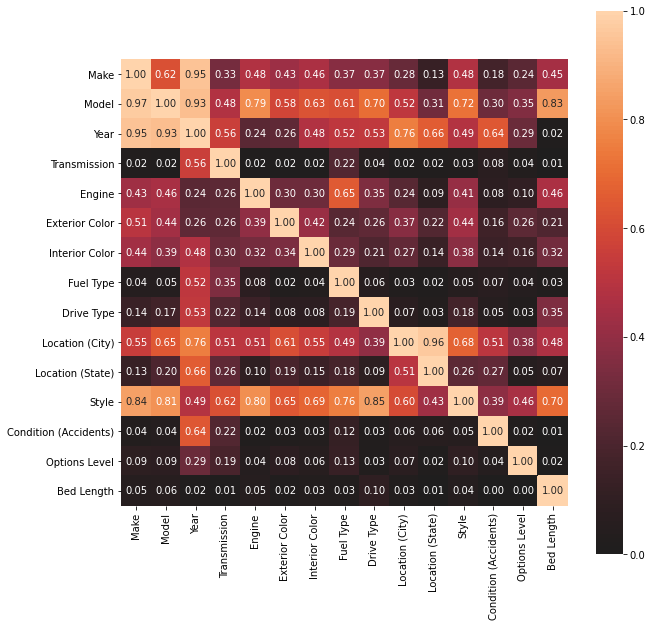

In [98]:
dn.associations(
    categorical_data.dropna(),
    theil_u=True, nan_strategy='drop_samples', figsize=(10,10))['ax']

Then, 'Location (City)' will be eliminated.

In [136]:
vehicles_dataset.drop(columns='Location (City)', inplace=True)

Location (State)' has still a lot of null values to deal with.
Another category representing them will is created.

In [99]:
vehicles_dataset['Location (State)'].value_counts()

TX     1997
FL     1675
CA     1652
AZ      803
NC      771
VA      762
0.0     748
IL      715
GA      583
WA      480
TN      429
NJ      427
CO      415
PA      349
OH      341
MD      336
NY      327
MA      282
SC      279
IN      277
OK      240
AL      223
MO      221
KY      220
OR      217
CT      197
UT      174
NV      162
LA      141
AR      138
WI      137
MN      126
MI      119
KS      114
IA       95
HI       92
NE       85
NH       80
MS       76
ME       76
NM       71
ID       69
MT       49
WY       32
DE       29
AK       24
SD       21
VT       15
RI       13
ND       11
WV        3
UK        1
SO        1
Name: Location (State), dtype: int64

In [115]:
#np.where(vehicles_dataset['Location (State)'] == 'UK', 'Other', vehicles_dataset['Location (State)'])

array(['WA', 'TX', 'CA', ..., 'TX', 'TX', 'TX'], dtype=object)

In [135]:
vehicles_dataset['Location (State)'].apply(lambda st: (st, 'Other')[st in ['UK', 'SO', 'WV', np.NaN]]).value_counts()

TX       1997
FL       1675
CA       1652
AZ        803
NC        771
VA        762
Other     753
IL        715
GA        583
WA        480
TN        429
NJ        427
CO        415
PA        349
OH        341
MD        336
NY        327
MA        282
SC        279
IN        277
OK        240
AL        223
MO        221
KY        220
OR        217
CT        197
UT        174
NV        162
LA        141
AR        138
WI        137
MN        126
MI        119
KS        114
IA         95
HI         92
NE         85
NH         80
ME         76
MS         76
NM         71
ID         69
MT         49
WY         32
DE         29
AK         24
SD         21
VT         15
RI         13
ND         11
Name: Location (State), dtype: int64